# Integrating mouse embryo cell atlas data using scVI
In this notebook, we will use scVI to integrate the data in mouse embryo datasets.
We measure the quality of integration with metrics from [_Luecken, M.D., Büttner, M., Chaichoompu, K. et al. Benchmarking atlas-level data integration in single-cell genomics. Nat Methods 19, 41–50 (2022)._](https://doi.org/10.1038/s41592-021-01336-8)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import scib
import scanpy as sc
import scvi

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/torch/utils/tensorboard/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  tensorboard.__version__
/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
Global seed set to 0


In [2]:
adata_orig = sc.read('../data/raw_e55/Concatenated_E55.h5ad')

In [3]:
adata = sc.read('../data/raw_e55/Concatenated_E55.h5ad')
adata

AnnData object with n_obs × n_vars = 12239 × 15456
    obs: 'cell_type', 'batch_id', 'batch'
    var: 'gene_symbol-0', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_id_colors', 'cell_type_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
adata.layers['counts'] = adata.X.copy()

In [5]:
adata_raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=4000,
    batch_key="batch_id",
    subset=True
)

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,


### Setup the scVI model

In [6]:
scvi.model.SCVI.setup_anndata(adata, batch_key="batch_id", layer="counts")

In [7]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

### Train the model

In [8]:
vae.train()

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/torch/distributed/_sharded_tensor/__init__.py:10: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  DeprecationWarning
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [06:40<00:00,  1.00s/it, loss=2.72e+03, v_num=1]


In [9]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

### Save the new anndata to a file

In [10]:
sc.write('data_copy/scVI_integrated.h5ad', adata)

In [11]:
adata = sc.read('data_copy/scVI_integrated.h5ad')

## Visualize the integrated data

Use a coarse resolution to get leiden clusters ~ cell types

In [16]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata, resolution=0.1)
sc.tl.umap(adata)

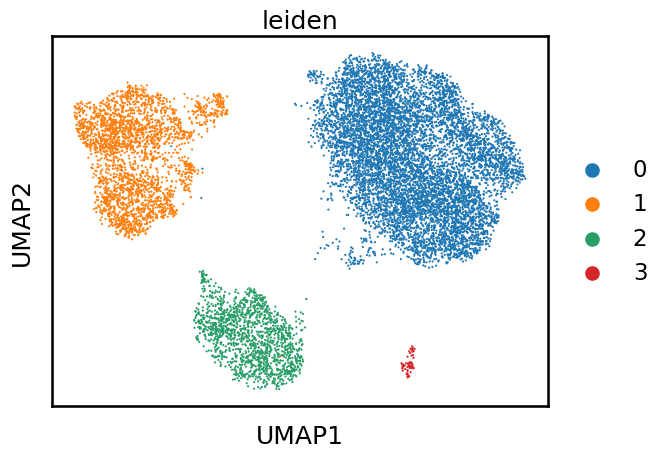

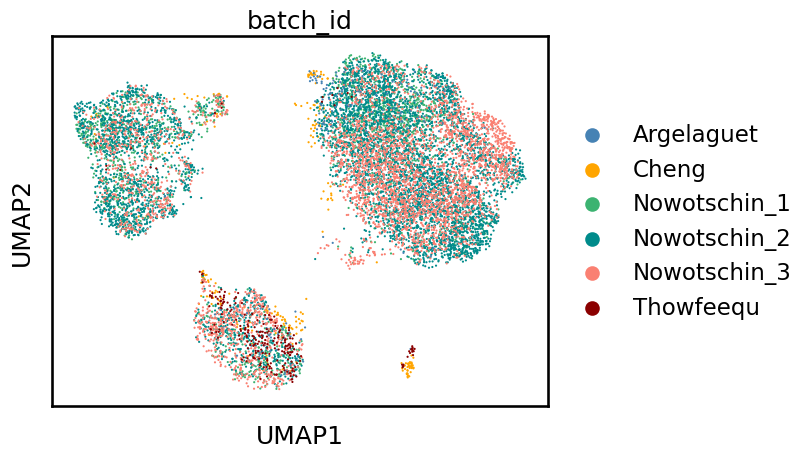

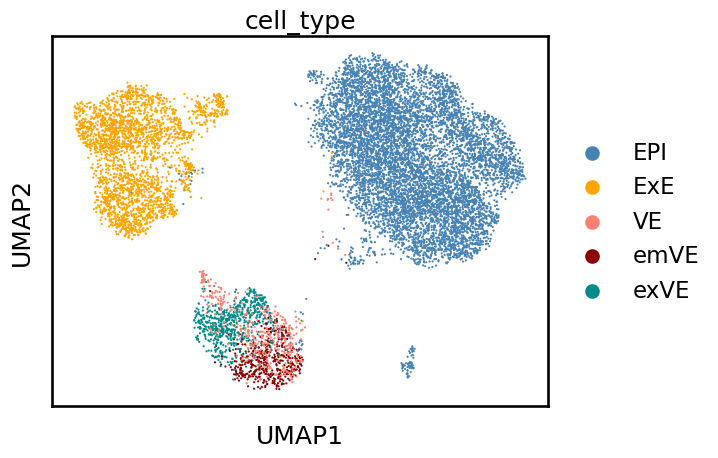

In [17]:
sc.pl.umap(adata, color=['leiden'])
sc.pl.umap(adata, color=['batch_id'])
sc.pl.umap(adata, color=['cell_type'])

### PCA

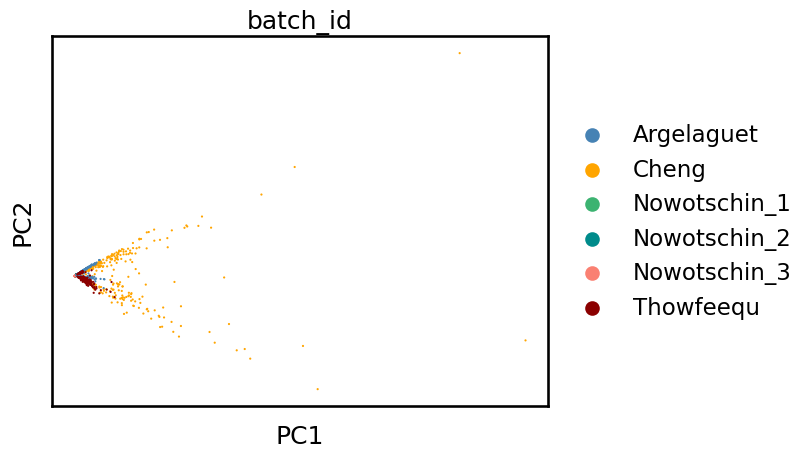

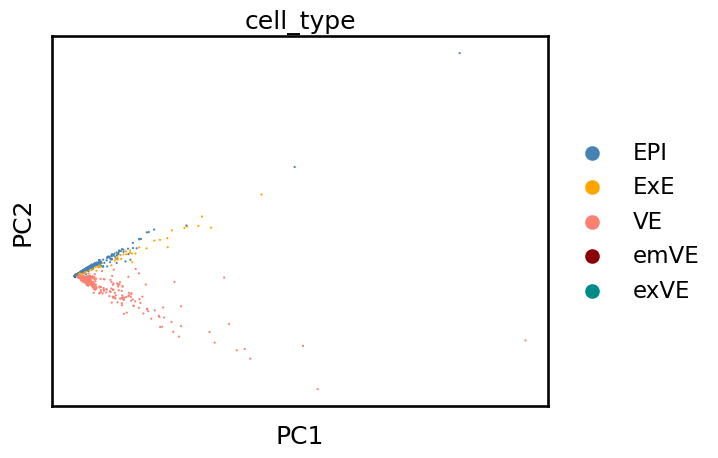

In [42]:
sc.pl.pca(adata, color=['batch_id'])
sc.pl.pca(adata, color=['cell_type'])

### t-SNE

In [31]:
sc.tl.tsne(adata)

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


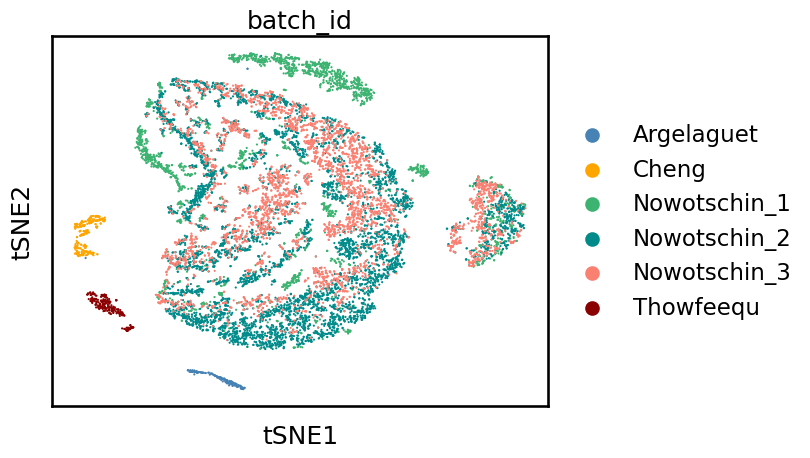

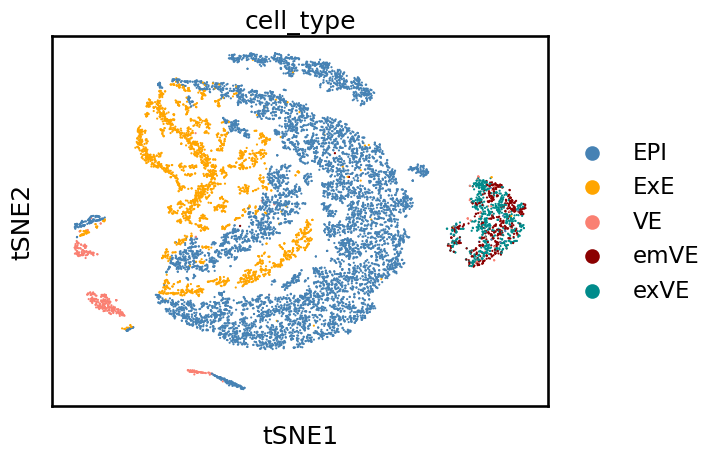

In [33]:
sc.pl.tsne(adata, color=['batch_id'])
sc.pl.tsne(adata, color=['cell_type'])

### Diffusion map

In [38]:
sc.tl.diffmap(adata)

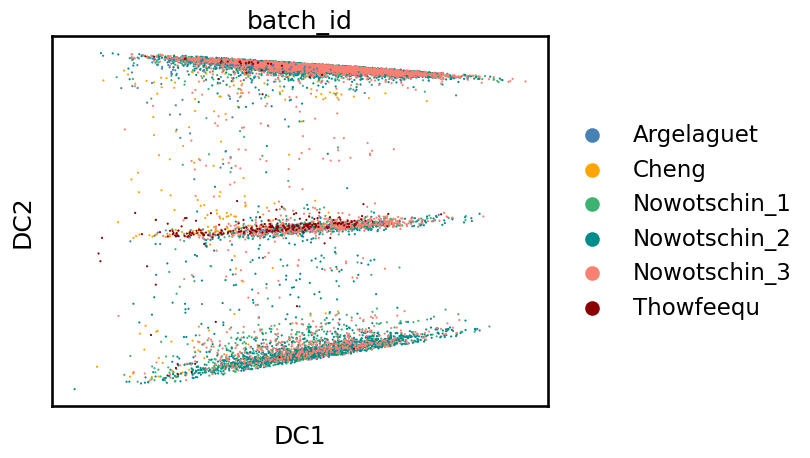

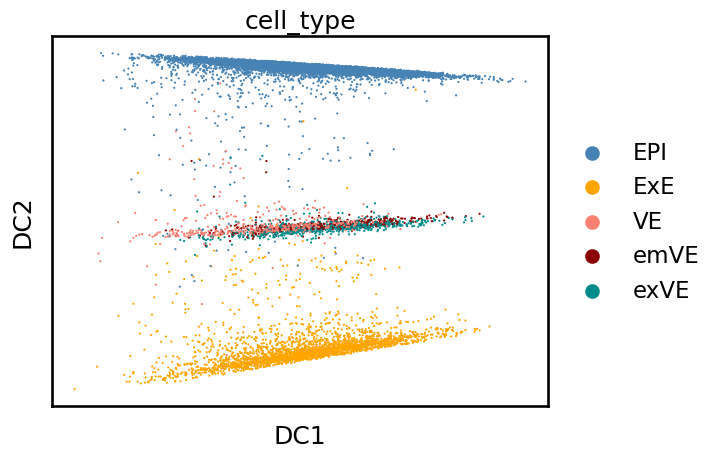

In [43]:
sc.pl.diffmap(adata, color=['batch_id'])
sc.pl.diffmap(adata, color=['cell_type'])

### Analysis
Looking at the above plots of the calculated latent representation, we can argue, that the integration worked well. The batches are somewhat mixed, and the cell types still cluster together.

### Calculate Metrics
_TODO_: iLISI / cLISI don't work; only metrics_fast doesn't throw an error

In [18]:
# scvi_metrics = scib.metrics.metrics_all(adata_orig, adata, batch_key='batch_id', label_key='cell_type', embed='X_scVI')
scvi_metrics = scib.metrics.metrics(adata_orig, adata, batch_key='batch_id', label_key='cell_type', embed='X_scVI', cluster_key='cluster', cluster_nmi=None, ari_=True,
                        nmi_=True, nmi_method='arithmetic', nmi_dir=None, silhouette_=True, si_metric='euclidean', pcr_=True,
                        cell_cycle_=True, organism='mouse', hvg_score_=True, isolated_labels_=True, isolated_labels_f1_=True,
                        isolated_labels_asw_=True, n_isolated=None, graph_conn_=True, trajectory_=False, kBET_=True, lisi_graph_=True,
                        ilisi_=True, clisi_=True, subsample=0.5, n_cores=1, type_=None, verbose=True)
scvi_metrics

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scib/metrics/metrics.py:302: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  force=True,


Clustering...
resolution: 0.1, nmi: 0.8710130663827633
resolution: 0.2, nmi: 0.8570213356277068
resolution: 0.3, nmi: 0.6984638081190357
resolution: 0.4, nmi: 0.6285207702059045
resolution: 0.5, nmi: 0.594724293587896
resolution: 0.6, nmi: 0.5471341394209455
resolution: 0.7, nmi: 0.5423713581650672
resolution: 0.8, nmi: 0.5485059459526566
resolution: 0.9, nmi: 0.5433912763264093
resolution: 1.0, nmi: 0.5000185771902689
resolution: 1.1, nmi: 0.5007306526353461
resolution: 1.2, nmi: 0.4829356109126937
resolution: 1.3, nmi: 0.49041010758867426
resolution: 1.4, nmi: 0.4810955498551842
resolution: 1.5, nmi: 0.4754898610835943
resolution: 1.6, nmi: 0.4506865950915346
resolution: 1.7, nmi: 0.4405687798195775
resolution: 1.8, nmi: 0.44272888164254814
resolution: 1.9, nmi: 0.42943987086169344
resolution: 2.0, nmi: 0.41818178786393734
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.8710130663827633
NMI...
ARI...
Silhouette score...
PC regression...
covaria

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  np.array(score).ravel(), index=adata.obs_names, dtype='float64'
/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  np.array(score).ravel(), index=adata.obs_names, dtype='float64'
/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  np.array(score).ravel(), index=adata.obs_names, dtype='float64'
/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.o

Isolated labels F1...
Compute neighbors on rep X_scVI
Compute neighbors on rep X_scVI
Isolated labels ASW...
Graph connectivity...
kBET...
batch: batch_id
Use 17 nearest neighbors.
importing expression matrix
kBET estimation
Number of kBET tests is set to 43.


/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:266: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  category=DeprecationWarning)
/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/rpy2/robjects/numpy2ri.py:208: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  category=DeprecationWarning)


Use 70 nearest neighbors.
importing expression matrix
kBET estimation
Number of kBET tests is set to 814.
Use 70 nearest neighbors.
importing expression matrix
kBET estimation
Number of kBET tests is set to 262.
Use 37 nearest neighbors.
importing expression matrix
kBET estimation
Number of kBET tests is set to 45.
Use 51 nearest neighbors.
importing expression matrix
kBET estimation
Number of kBET tests is set to 62.
cLISI score...
using precomputed kNN graph
Convert nearest neighbor matrix and distances for LISI.
Compute knn on shortest paths


/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scib/metrics/lisi.py:175: UserWarning: 'batch_key' is deprecated and will be ignore
  warnings.warn("'batch_key' is deprecated and will be ignore")


call /home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scib/knn_graph/knn_graph.o /tmp/lisi_58qdgily/graph_lisi_input.mtx /tmp/lisi_58qdgily/graph_lisi 90 1 50
LISI score estimation
iLISI score...
using precomputed kNN graph
Convert nearest neighbor matrix and distances for LISI.
Compute knn on shortest paths
call /home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scib/knn_graph/knn_graph.o /tmp/lisi_qk5ab862/graph_lisi_input.mtx /tmp/lisi_qk5ab862/graph_lisi 90 1 50
LISI score estimation


,0
NMI_cluster/label,0.871013
ARI_cluster/label,0.949516
ASW_label,0.570961
ASW_label/batch,0.939158
PCR_batch,0.945224
cell_cycle_conservation,0.346743
isolated_label_F1,0.779437
isolated_label_silhouette,0.546395
graph_conn,0.993669
kBET,0.463976


In [48]:
def style(styler):
    styler.set_caption("<h3>scVI metrics</h3>")
    styler.background_gradient(axis=None, vmin=0, vmax=1, cmap="YlGnBu")
    return styler
scvi_metrics.style.pipe(style)

,0
NMI_cluster/label,0.871013
ARI_cluster/label,0.949516
ASW_label,0.570961
ASW_label/batch,0.939158
PCR_batch,0.945224
cell_cycle_conservation,0.346743
isolated_label_F1,0.779437
isolated_label_silhouette,0.546395
graph_conn,0.993669
kBET,0.463976
